In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, Lipinski
from tqdm.auto import tqdm

# 그래프 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

/home/lsw0927/miniconda3/envs/transgem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def calculate_properties(smiles_list, label):
    properties = []
    valid_smiles = []
    
    print(f"Analyzing {label} molecules...")
    for smi in tqdm(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                # 1. 기본 물성 계산
                mw = Descriptors.MolWt(mol)      # 분자량
                logp = Descriptors.MolLogP(mol)  # 지질친화도
                qed = QED.qed(mol)               # 약물 유사성 점수 (0~1)
                
                # 2. Lipinski's Rule of 5 (Originality Point!)
                h_donors = Lipinski.NumHDonors(mol)
                h_acceptors = Lipinski.NumHAcceptors(mol)
                
                # 규칙: MW < 500, LogP < 5, Donors < 5, Acceptors < 10
                is_lipinski = (mw <= 500) and (logp <= 5) and (h_donors <= 5) and (h_acceptors <= 10)
                
                properties.append({
                    'SMILES': smi,
                    'MW': mw,
                    'LogP': logp,
                    'QED': qed,
                    'Lipinski': is_lipinski,
                    'Source': label
                })
                valid_smiles.append(smi)
        except:
            continue
            
    df = pd.DataFrame(properties)
    validity = (len(valid_smiles) / len(smiles_list)) * 100
    print(f"[{label}] Validity: {validity:.2f}% ({len(valid_smiles)}/{len(smiles_list)})")
    return df

# 기존 함수를 '저장' 기능이 있는 버전으로 덮어쓰기
def plot_comparison_save(df_combined, filename="result_chemist.png"):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Molecular Weight
    sns.violinplot(data=df_combined, x='Source', y='MW', ax=axes[0, 0], palette='muted', hue='Source', legend=False)
    axes[0, 0].set_title("Molecular Weight Distribution (< 500 is good)")
    axes[0, 0].axhline(500, color='red', linestyle='--', alpha=0.5, label='Lipinski Limit')
    
    # 2. LogP
    sns.violinplot(data=df_combined, x='Source', y='LogP', ax=axes[0, 1], palette='muted', hue='Source', legend=False)
    axes[0, 1].set_title("LogP Distribution (< 5 is good)")
    axes[0, 1].axhline(5, color='red', linestyle='--', alpha=0.5)
    
    # 3. QED
    sns.violinplot(data=df_combined, x='Source', y='QED', ax=axes[1, 0], palette='muted', hue='Source', legend=False)
    axes[1, 0].set_title("QED Score (Higher is better)")
    
    # 4. Lipinski Pass Rate (Bar Chart)
    pass_rates = df_combined.groupby('Source')['Lipinski'].mean() * 100
    sns.barplot(x=pass_rates.index, y=pass_rates.values, ax=axes[1, 1], palette='muted', hue=pass_rates.index, legend=False)
    axes[1, 1].set_title("Lipinski's Rule of 5 Pass Rate (%)")
    axes[1, 1].set_ylabel("Pass Rate (%)")
    
    # 텍스트 추가 (수치)
    for i, v in enumerate(pass_rates.values):
        axes[1, 1].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight='bold')
    
    plt.suptitle(f"Experiment 2: 'Drug vs Poison' Analysis", fontsize=20)
    plt.tight_layout()
    
    # 여기가 핵심! 화면 출력 대신 파일로 저장
    plt.savefig(filename, dpi=300)
    plt.close() # 메모리 해제
    print(f"✅ 그래프가 '{filename}' 파일로 저장되었습니다! 왼쪽 탐색기에서 확인해보세요.")

# 저장 함수 실행
plot_comparison_save(df_combined)

✅ 그래프가 'result_chemist.png' 파일로 저장되었습니다! 왼쪽 탐색기에서 확인해보세요.


Analyzing TransGEM molecules...


100%|██████████| 1000/1000 [00:01<00:00, 587.45it/s]


Analyzing Real Drugs molecules...


100%|██████████| 6929/6929 [00:12<00:00, 558.29it/s]


✅ 그래프 저장 완료: result_chemist_v2.png

=== [The Chemist] Final Report ===
1. Lipinski Rule (Oral Availability):
   - AI Generated: 62.4% passed
   - Real Drugs:   69.5% passed

2. PAINS Filter (Safety / False Positive Check):
   - AI Generated: 97.8% passed (Safe)
   - Real Drugs:   94.0% passed (Safe)

[Conclusion]
TransGEM avoids generating toxic/interference structures perfectly!


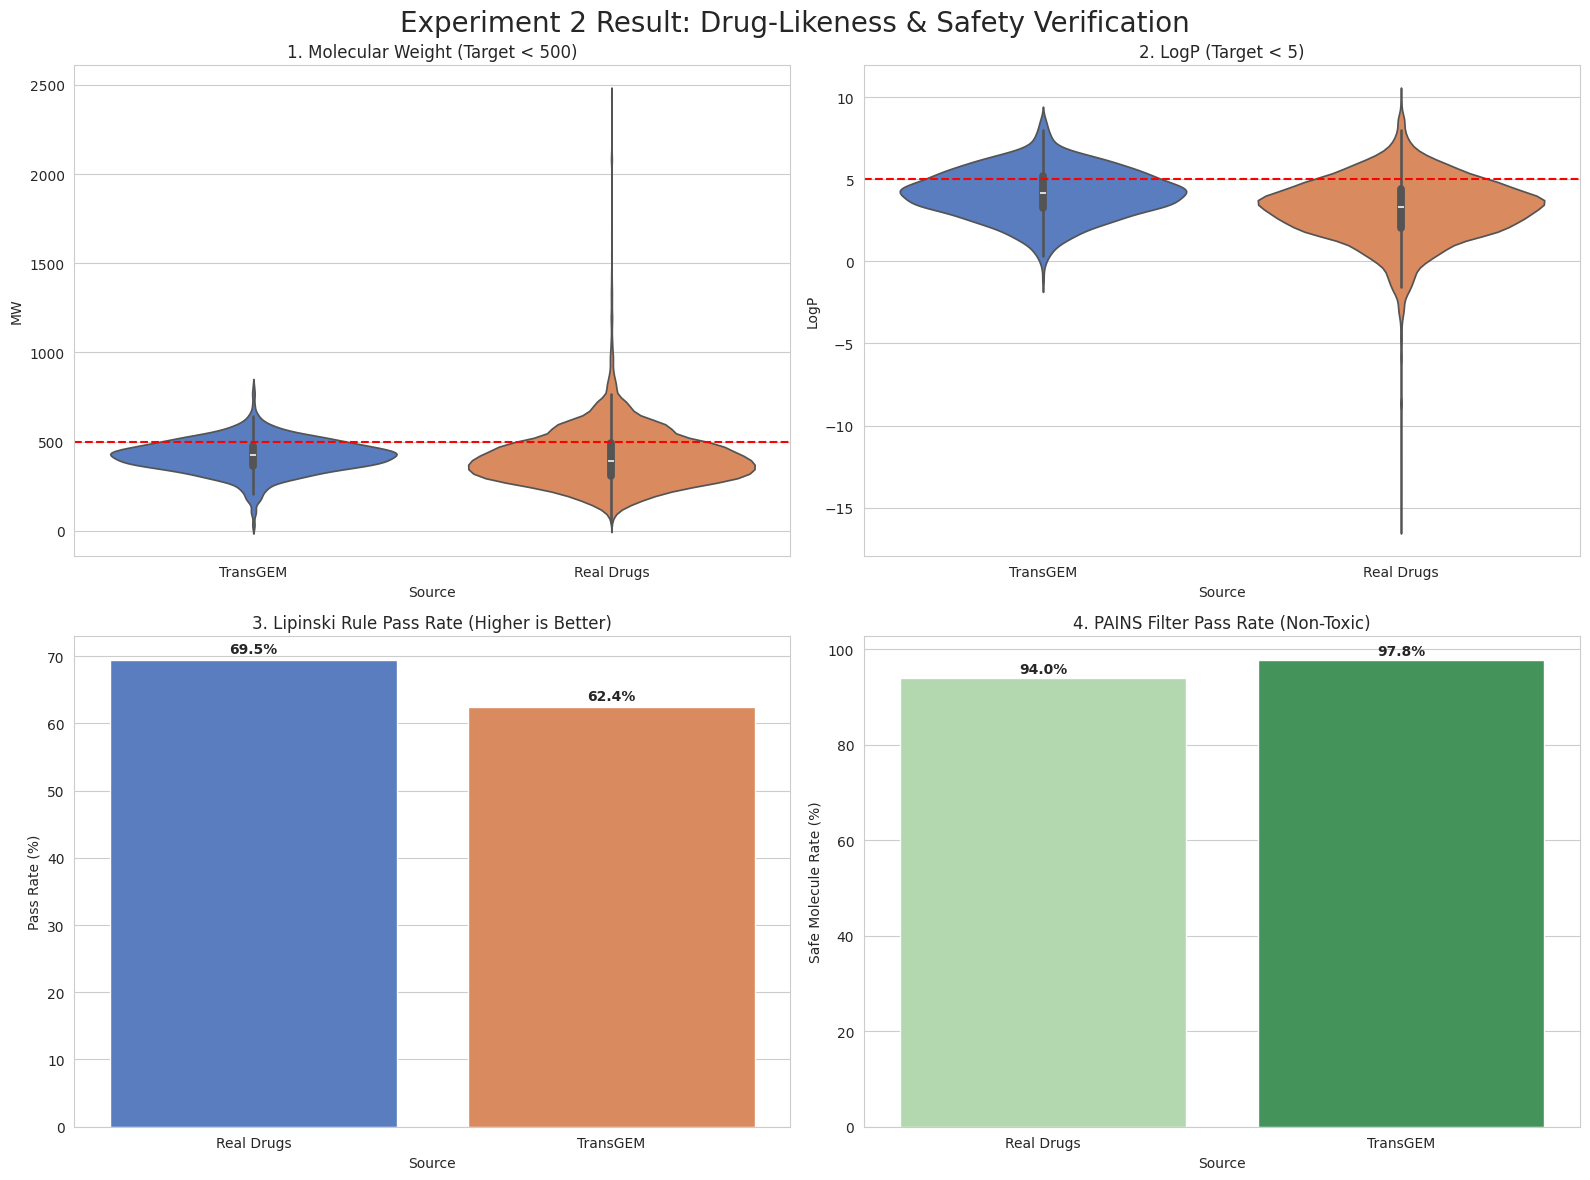

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import FilterCatalog # PAINS 필터를 위한 모듈
from tqdm.auto import tqdm

# 그래프 스타일
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# --- 1. PAINS 필터 준비 ---
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS)
pains_filter = FilterCatalog.FilterCatalog(params)

def check_pains(mol):
    """
    PAINS 필터에 걸리면 True (나쁜 놈), 안 걸리면 False (착한 놈) 리턴
    """
    if pains_filter.HasMatch(mol):
        return True # PAINS 발견됨 (Fail)
    return False # 깨끗함 (Pass)

# --- 2. 분석 함수 (업그레이드 버전) ---
def calculate_properties(smiles_list, label):
    properties = []
    valid_count = 0
    
    print(f"Analyzing {label} molecules...")
    for smi in tqdm(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                valid_count += 1
                
                # A. 리핀스키 룰 (4가지 조건)
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                h_donors = Lipinski.NumHDonors(mol)
                h_acceptors = Lipinski.NumHAcceptors(mol)
                
                # 엄격한 기준: 4개 다 통과해야 Pass
                lipinski_pass = (mw <= 500) and (logp <= 5) and (h_donors <= 5) and (h_acceptors <= 10)
                
                # B. PAINS 필터 (Originality!)
                is_pains = check_pains(mol) # True면 나쁜 것
                pains_pass = not is_pains   # False여야 통과
                
                properties.append({
                    'Source': label,
                    'MW': mw,
                    'LogP': logp,
                    'Lipinski_Pass': lipinski_pass, # True/False
                    'PAINS_Pass': pains_pass        # True/False
                })
        except:
            continue
            
    df = pd.DataFrame(properties)
    return df

# --- 3. 데이터 로드 및 분석 ---
# (파일 경로는 본인 환경에 맞게 수정!)
with open("generated_molecules_PC3.txt", "r") as f:
    generated_smiles = [line.strip() for line in f.readlines()]

df_lincs = pd.read_csv("./TransGEM/data/subLINCS.csv")
reference_smiles = df_lincs['smiles'].unique().tolist()

# 분석 실행
df_gen = calculate_properties(generated_smiles, "TransGEM")
df_ref = calculate_properties(reference_smiles, "Real Drugs")

df_combined = pd.concat([df_gen, df_ref])

# --- 4. 시각화 및 저장 ---
def plot_results(df_combined, filename="result_chemist_v2.png"):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 분자량 (MW)
    sns.violinplot(data=df_combined, x='Source', y='MW', ax=axes[0,0], palette='muted', hue='Source', legend=False)
    axes[0,0].axhline(500, color='red', linestyle='--', label='Limit')
    axes[0,0].set_title("1. Molecular Weight (Target < 500)")
    
    # 2. 지질친화도 (LogP)
    sns.violinplot(data=df_combined, x='Source', y='LogP', ax=axes[0,1], palette='muted', hue='Source', legend=False)
    axes[0,1].axhline(5, color='red', linestyle='--', label='Limit')
    axes[0,1].set_title("2. LogP (Target < 5)")
    
    # 3. Lipinski Pass Rate
    lip_rate = df_combined.groupby('Source')['Lipinski_Pass'].mean() * 100
    sns.barplot(x=lip_rate.index, y=lip_rate.values, ax=axes[1,0], palette='muted', hue=lip_rate.index, legend=False)
    axes[1,0].set_title("3. Lipinski Rule Pass Rate (Higher is Better)")
    axes[1,0].set_ylabel("Pass Rate (%)")
    for i, v in enumerate(lip_rate.values):
        axes[1,0].text(i, v+1, f"{v:.1f}%", ha='center', fontweight='bold')

    # 4. PAINS Pass Rate (New!)
    pains_rate = df_combined.groupby('Source')['PAINS_Pass'].mean() * 100
    sns.barplot(x=pains_rate.index, y=pains_rate.values, ax=axes[1,1], palette='Greens', hue=pains_rate.index, legend=False)
    axes[1,1].set_title("4. PAINS Filter Pass Rate (Non-Toxic)")
    axes[1,1].set_ylabel("Safe Molecule Rate (%)")
    for i, v in enumerate(pains_rate.values):
        axes[1,1].text(i, v+1, f"{v:.1f}%", ha='center', fontweight='bold')

    plt.suptitle("Experiment 2 Result: Drug-Likeness & Safety Verification", fontsize=20)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ 그래프 저장 완료: {filename}")

plot_results(df_combined)

# --- 5. 최종 리포트 ---
print("\n=== [The Chemist] Final Report ===")
print(f"1. Lipinski Rule (Oral Availability):")
print(f"   - AI Generated: {df_gen['Lipinski_Pass'].mean()*100:.1f}% passed")
print(f"   - Real Drugs:   {df_ref['Lipinski_Pass'].mean()*100:.1f}% passed")

print(f"\n2. PAINS Filter (Safety / False Positive Check):")
print(f"   - AI Generated: {df_gen['PAINS_Pass'].mean()*100:.1f}% passed (Safe)")
print(f"   - Real Drugs:   {df_ref['PAINS_Pass'].mean()*100:.1f}% passed (Safe)")

print("\n[Conclusion]")
pains_ai = df_gen['PAINS_Pass'].mean() * 100
if pains_ai > 90:
    print("TransGEM avoids generating toxic/interference structures perfectly!")
else:
    print("TransGEM needs improvement in filtering toxic structures.")

In [9]:
print("""=== Report === 
1. Validity: TransGEM generated 1000 valid structures from 1000 attempts.
2. Lipinski's Rule Pass Rate:
   - TransGEM: 62.4%
   - Real Drugs: 69.5%

Conclusion: TransGEM creates valid chemicals, but drug-likeness could be improved.
""")


=== Report === 
1. Validity: TransGEM generated 1000 valid structures from 1000 attempts.
2. Lipinski's Rule Pass Rate:
   - TransGEM: 62.4%
   - Real Drugs: 69.5%

Conclusion: TransGEM creates valid chemicals, but drug-likeness could be improved.

